# In this notebook, we will explain multi-head attention(MHA), multi-query atention(MQA), and group-query attention(GQA).

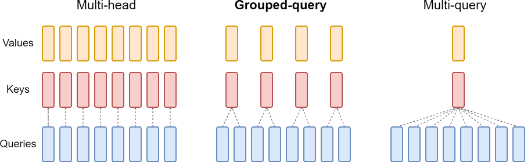

# What are keys, values, and queries?
## **Keys:** what information the keys matrices contain of.

## **Queries:** What information the queries matrices look for.

## **Values:** The matrices where elements communicate with each other in time -axis.

One way the elements of the values system can interact with each other by taking the average of the all the elements in the time axis. That means we force all tokens to come equally likely after a token at the begenning of the training, which is not goog because a token may have higher preferences for a different token than all other tokens.

We introduce the weighted average of the elements of the values matrices by introducing the dot product of the keys and queries.  

#**Multi-head Attention(MHA)**

In [ ]:
"""Here we will write the code for the multi-head attention.

As can be seen in the figure, the keys, values, and queris have the same number of heads. Each column in the fighure can be thought as a head.
"""

import torch
import torch.nn as nn
from dataclasses import dataclass
import time



class MultiHeadAtention(nn.Module):
  def __init__(self, args) -> None:
    super().__init__()

    self.q = nn.Linear(args.embedding_size, args.embedding_size); '(C, C)'
    self.k = nn.Linear(args.embedding_size, args.embedding_size); '(C, C)'
    self.v = nn.Linear(args.embedding_size, args.embedding_size); '(C, C)'
    self.args = args

  def forward(self, x, mask = True):
    """ x is a matrix of size (B, T, C). B=batch size, T= time step or sequence length, C = embedding dimension. x[0, 0, :] is the size of
    the one embedding vector of size C that is generated for only one token. So, x contains the embeddings vectors of B*T tokens.
    nh is the number of heads.
    """
    B, T, C = x.shape

    qx = self.q(x); '(B, T, C) @ (C, C) ----> (B, T, C) @ (B, C, C) ---> (B, T, C)'
    kx = self.k(x); '(B, T, C) @ (C, C) ----> (B, T, C) @ (B, C, C) ---> (B, T, C)'
    vx = self.v(x); '(B, T, C) @ (C, C) ----> (B, T, C) @ (B, C, C) ---> (B, T, C)'

    qx = qx.view(B, T, self.args.n_head, C //  self.args.n_head); '(B, T, nh, C/nh)'
    kx = kx.view(B, T, self.args.n_head, C //  self.args.n_head); '(B, T, nh, C/nh)'
    vx = vx.view(B, T, self.args.n_head, C //  self.args.n_head); '(B, T, nh, C/nh)'


    qx = qx.transpose(1, 2); '(B, nh, T, C/nh)'
    kx = kx.transpose(1, 2); '(B, nh, T, C/nh)'
    vx = vx.transpose(1, 2); '(B, nh, T, C/nh)'

    weight = kx @ qx.transpose(-1, -2); '(B, nh, T, C/nh) @ (B, nh, C/nh, T) ----> (B, nh, T, T)'

    if mask:
      mask = torch.full((T, T), float('-inf'), device = x.device)
      mask = torch.triu(mask, diagonal = 1)
      weight = weight + mask; '(B, nh, T, T) + (T, T) ---> (B, nh, T, T) + (B, nh, T, T) ----> (B, nh, T, T)'

    weight = torch.softmax(weight, dim = -1); '(B, nh, T, T)'

    #vx = vx.transpose(1, 2); '(B, T, nh, C/nh)'

    out = weight @ vx; '(B, nh, T, T) @ (B, nh, T, C/nh) ----> (B, nh, T, C/nh)'
    out = out.transpose(1, 2); '(B, nh, T, C/nh) ----> (B, T, nh, C/nh)'


    out = out.contiguous().view(B, T, C); '(B, T, nh, C/nh) ----> (B, T, nh * C/nh) ----> (B, T, C)'

    return out

@dataclass
class args:
  B:int = 4
  T:int = 728
  embedding_size:int = 1024
  n_head:int = 256

x = torch.rand((args.B, args.T, args.embedding_size))
model = MultiHeadAtention(args)
model(x).shape

t1 = time.time()
model(x).shape
t2 = time.time()
print(f'time needed = {t2 - t1}')


# Multi-query Attention(MQA)

#Why do we need MQA over MHA?
**Answer:** In MHA, the queries, values, and keys have the same number of heads that leads to large memory requirements and more computation time. In MQA, the number of heads for values and keys are 1, this leads to less memory requirements and less computation time.

MQA needs less memory and less computation but performe a little lower than the MHA.

In [ ]:
from typing import Optional
"""Here we will write the code for the multi-query attention.

As can be seen in the figure, the keys and values have only one head where as queris have more than one head. Each column in the fighure can be thought as a head.
"""

import torch
import torch.nn as nn
from dataclasses import dataclass
import time
from typing import Optional



class MultiQueryAtention(nn.Module):
  def __init__(self, args) -> None:
    super().__init__()

    self.n_kv_heads = args.n_head if args.n_kv_heads is None else args.n_kv_heads
    kv_head_dim = args.embedding_size // self.n_kv_heads

    self.args = args
    self.num_rep = args.n_head // args.n_kv_head

    self.q = nn.Linear(args.embedding_size, args.n_head * args.embedding_size // args.n_head); '(C, C)'
    self.k = nn.Linear(args.embedding_size, self.n_kv_heads*args.embedding_size // args.n_head); '(C, C // num_kv_head) ---> (C, kv_head_dim)'
    self.v = nn.Linear(args.embedding_size, self.n_kv_heads*args.embedding_size // args.n_head); '(C, c // num_kv_head) ---> (C, kv_head_dim)'

    """ kv_head_dim = n_kv_heads*args.embedding_size // args.n_head
    """

  def forward(self, x, mask = True):
    """ x is a matrix of size (B, T, C). B=batch size, T= time step or sequence length, C = embedding dimension. x[0, 0, :] is the size of
    the one embedding vector of size C that is generated for only one token. So, x contains the embeddings vectors of B*T tokens.
    nh is the number of heads. n_kv_head is the number of heads for keys and values. Here, n_kv_head = 1.
    """
    B, T, C = x.shape

    qx = self.q(x); '(B, T, C) @ (C, C) ----> (B, T, C) @ (B, C, C) ---> (B, T, C)'
    kx = self.k(x); '(B, T, C) @ (C, n_kv_head) ----> (B, T, C) @ (B, C, kv_head_dim) ---> (B, T, kv_head_dim) or (B, T, C // num_head)'
    vx = self.v(x); '(B, T, C) @ (C, n_kv_head) ----> (B, T, C) @ (B, C, kv_head_dim) ---> (B, T, kv_head_dim) or (B, T, C // num_head)'

    qx = qx.view(B, T, self.args.n_head, C //  self.args.n_head); '(B, T, nh, C/nh)'
    kx = kx.view(B, T, self.n_kv_heads, C //  self.args.n_head); '(B, T, n_kv_heads, C/nh)'
    vx = vx.view(B, T, self.n_kv_heads, C //  self.args.n_head); '(B, T, n_kv_heads, C/nh)'


    qx = qx.transpose(1, 2); '(B, nh, T, C/nh)'
    kx = kx.transpose(1, 2); '(B, n_kv_heads, T, C/nh)'
    vx = vx.transpose(1, 2); '(B, n_kv_heads, T, C/nh)'

    if kx.shape[1] != 1: #n_kv_heads = 1, we do not need to repeat. That dimension will be broadcasted.
      kx = kx.repeat(1, self.num_rep, 1, 1); '(B, n_kv_heads, T, C/nh) ----> (B, nh, T, C/nh)'
      vx = vx.repeat(1, self.num_rep, 1, 1); '(B, n_kv_heads, T, C/nh) ----> (B, nh, T, C/nh)'

    weight = kx @ qx.transpose(-1, -2); '(B, nh, T, C/nh) @ (B, nh, C/nh, T) ----> (B, nh, T, C/nh) @ (B, nh, C/nh, T) ---> (B, nh, T, T)'

    if mask:
      mask = torch.full((T, T), float('-inf'), device = x.device)
      mask = torch.triu(mask, diagonal = 1)
      weight = weight + mask; '(B, nh, T, T) + (T, T) ---> (B, nh, T, T) + (B, nh, T, T) ----> (B, nh, T, T)'

    weight = torch.softmax(weight, dim = -1); '(B, nh, T, T)'
    out = weight @ vx; '(B, nh, T, T) @ (B, nh, T, C/nh) ----> (B, nh, T, T) @ (B, nh, T, C/nh) ---> (B, nh, T, C/nh)'
    out = out.transpose(1, 2); '(B, nh, T, C/nh) ----> (B, T, nh, C/nh)'
    out = out.contiguous().view(B, T, C); '(B, T, nh, C/nh) ----> (B, T, nh * C/nh) ----> (B, T, C)'
    return out



@dataclass
class args:
  B:int = 4
  T:int = 728
  embedding_size:int = 1024
  n_head:int = 256
  n_kv_head:Optional[int] = 1

x = torch.rand((args.B, args.T, args.embedding_size))
model = MultiHeadAtention(args)

t1 = time.time()
model(x).shape
t2 = time.time()
print(f'time needed = {t2 - t1}')



# Group-query Attention(GQA)

##Why do we need GQA over MHA and MQA?

**Answer:** MHA requires more time computation and memory requirements and performs better, where as MQA requires less time computation and memory requirements but performe lesser than MHA. GQA is the combination of MHA and MQA. If we make n_kv_heads = 1 in GQA, we reach to MQA. If we make n_kv_heads = n_heads, we reach to MHA. GQA requires less memory and time computation than MHA, but performs like MHA.

In [ ]:
from typing import Optional
"""Here we will write the code for the Group-query attention.

As can be seen in the figure, the keys and values have lesser number of heads where as queris have more number of heads than keys and values. Each column in the fighure can be thought as a head.
"""

import torch
import torch.nn as nn
from dataclasses import dataclass
import time
from typing import Optional



class GroupQueryAtention(nn.Module):
  def __init__(self, args) -> None:
    super().__init__()

    self.n_kv_heads = args.n_head if args.n_kv_heads is None else args.n_kv_heads
    kv_head_dim = args.embedding_size // self.n_kv_heads

    self.args = args
    self.num_rep = args.n_head // args.n_kv_head

    self.q = nn.Linear(args.embedding_size, args.n_head * args.embedding_size // args.n_head); '(C, C)'
    self.k = nn.Linear(args.embedding_size, self.n_kv_heads*args.embedding_size // args.n_head); '(C, C // num_kv_head) ---> (C, kv_head_dim)'
    self.v = nn.Linear(args.embedding_size, self.n_kv_heads*args.embedding_size // args.n_head); '(C, c // num_kv_head) ---> (C, kv_head_dim)'

    """ kv_head_dim = n_kv_heads*args.embedding_size // args.n_head
    """

  def forward(self, x, mask = True):
    """ x is a matrix of size (B, T, C). B=batch size, T= time step or sequence length, C = embedding dimension. x[0, 0, :] is the size of
    the one embedding vector of size C that is generated for only one token. So, x contains the embeddings vectors of B*T tokens.
    nh is the number of heads. n_kv_head is the number of heads for keys and values. Here, n_kv_head = 1.
    """
    B, T, C = x.shape

    qx = self.q(x); '(B, T, C) @ (C, C) ----> (B, T, C) @ (B, C, C) ---> (B, T, C)'
    kx = self.k(x); '(B, T, C) @ (C, n_kv_head) ----> (B, T, C) @ (B, C, kv_head_dim) ---> (B, T, kv_head_dim) or (B, T, C // num_head)'
    vx = self.v(x); '(B, T, C) @ (C, n_kv_head) ----> (B, T, C) @ (B, C, kv_head_dim) ---> (B, T, kv_head_dim) or (B, T, C // num_head)'

    qx = qx.view(B, T, self.args.n_head, C //  self.args.n_head); '(B, T, nh, C/nh)'
    kx = kx.view(B, T, self.n_kv_heads, C //  self.args.n_head); '(B, T, n_kv_heads, C/nh)'
    vx = vx.view(B, T, self.n_kv_heads, C //  self.args.n_head); '(B, T, n_kv_heads, C/nh)'


    qx = qx.transpose(1, 2); '(B, nh, T, C/nh)'
    kx = kx.transpose(1, 2); '(B, n_kv_heads, T, C/nh)'
    vx = vx.transpose(1, 2); '(B, n_kv_heads, T, C/nh)'

    if kx.shape[1] != 1: #n_kv_heads = 1, we do not need to repeat. That dimension will be broadcasted.
      kx = kx.repeat(1, self.num_rep, 1, 1); '(B, n_kv_heads, T, C/nh) ----> (B, nh, T, C/nh)'
      vx = vx.repeat(1, self.num_rep, 1, 1); '(B, n_kv_heads, T, C/nh) ----> (B, nh, T, C/nh)'

    weight = kx @ qx.transpose(-1, -2); '(B, nh, T, C/nh) @ (B, nh, C/nh, T) ----> (B, nh, T, C/nh) @ (B, nh, C/nh, T) ---> (B, nh, T, T)'

    if mask:
      mask = torch.full((T, T), float('-inf'), device = x.device)
      mask = torch.triu(mask, diagonal = 1)
      weight = weight + mask; '(B, nh, T, T) + (T, T) ---> (B, nh, T, T) + (B, nh, T, T) ----> (B, nh, T, T)'

    weight = torch.softmax(weight, dim = -1); '(B, nh, T, T)'
    out = weight @ vx; '(B, nh, T, T) @ (B, nh, T, C/nh) ----> (B, nh, T, T) @ (B, nh, T, C/nh) ---> (B, nh, T, C/nh)'
    out = out.transpose(1, 2); '(B, nh, T, C/nh) ----> (B, T, nh, C/nh)'
    out = out.contiguous().view(B, T, C); '(B, T, nh, C/nh) ----> (B, T, nh * C/nh) ----> (B, T, C)'
    return out



@dataclass
class args:
  B:int = 4
  T:int = 728
  embedding_size:int = 1024
  n_head:int = 256
  n_kv_head:Optional[int] = n_head // 2; 'This line can lead GQA to MHA if n_kv_head = n_head or None and lead to MQA if n_kv_head = 1.'

x = torch.rand((args.B, args.T, args.embedding_size))
model = MultiHeadAtention(args)

t1 = time.time()
model(x).shape
t2 = time.time()
print(f'time needed = {t2 - t1}')

